In [119]:
import numpy as np
import pandas as pd
import lightgbm as lgb

from sklearn import  model_selection, linear_model
from sklearn.metrics import mean_squared_log_error, recall_score
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsRegressor
from matplotlib import pyplot

import os
import matplotlib.pyplot as plt

In [120]:
data_dir = '../input/'

### Utils

In [121]:
def rmsle(est, x, y_test):
    """
    Метрика rmsle

    :est: обученный экземпляр модели
    :x: объекты на которых нужно предсказать значение
    :y_test: фактическое значение объектов
    :returns: значение метрики rmsle на выборке x
    """

    predict = est.predict(x)
    predict = [x if x > 0 else 0 for x in predict]
    return np.sqrt(mean_squared_log_error(y_test, predict ))


def regr_score(x_train, y_train, regr, scoring):
    """
    Расчет кроссвалидации и вывод на экран

    :x_train: обучающая выборка
    :y_train: целевое значение
    :regr: экземпляр модели
    :scoring: метрика
    """
    scores = cross_validate(regr, 
                            x_train, 
                            y_train, 
                            scoring=scoring,
                            cv=5, 
                            return_train_score=False)
    
    scores_list = scores[list(scores.keys())[-1]]
    print(scores_list)
    print(f'mean score -- {np.mean(scores_list)}')
    
    
def get_data():
    df_x = pd.read_csv(f'{data_dir}/train.csv')
    df_x = df_x.fillna(-1)
        
    y = df_x['label']
    df_x = df_x.drop(['label', 'status', 'short', 'activity_title', 'title_activity_type',
                      'activity_description', 'title_direction', 'comment_direction'], 
                     axis=1)
    return df_x, y


### Read data

In [122]:
df_x, y = get_data()
print(df_x.shape)
print(len(y))
print(df_x.columns)

(13000, 11)
13000
Index(['id_bet', 'run_id', 'user_id', 'direction_id', 'activity_id',
       'size_max', 'size_min', 'is_educational', 'is_checkin_required',
       'activity_type_id', 'main_competence_id'],
      dtype='object')


In [123]:
x_train = np.array(df_x)
y_train = np.array(y)

In [124]:
# Посмотрим, какие есть файлы и положим их в словарь
dfs = {}
for i, x in enumerate(os.listdir(data_dir)):
    file_name = x.split('.')[0]
    print(f'{i} -- {file_name}')
    dfs[file_name] = pd.read_csv(f'{data_dir}/{x}')

0 -- time_slot
1 -- event
2 -- activity_tag
3 -- train
4 -- user_role
5 -- activity_author
6 -- user_tag
7 -- place
8 -- competence_level
9 -- sample_submission
10 -- activity_track
11 -- test
12 -- competence
13 -- track
14 -- competence_type
15 -- role
16 -- author


### Simple prediction
Для начала нужно попробовать самые простые модели, чтобы примерно понимать, какое качество ожидать

In [125]:
# Наивная модель, где предсказанием является среднее значение, полученное на обучающей выборке
regr = DummyRegressor(strategy='mean')
regr_score(x_train, y_train, regr, rmsle)
print()

# Наивная модель, где предсказанием является медиана, полученная на обучающей выборке
# Эта статистика менее подвержена выбросам, поэтому, возможно, даст лучшее качество
regr = DummyRegressor(strategy='median')
regr_score(x_train, y_train, regr, rmsle)
print()

# Градиентный бустинг от Микрософта
regr = lgb.LGBMRegressor()
regr_score(x_train, y_train, regr, rmsle)
print()

# К средних соседей
regr = KNeighborsRegressor()
regr_score(x_train, y_train, regr, rmsle)


[3.17623168 2.64802335 1.97579148 1.95395719 1.93442136]
mean score -- 2.337685013625203

[2.28039206 1.64154422 1.45836226 1.9740166  2.50493593]
mean score -- 1.97185021481104

[1.60838369 1.92401204 1.54122362 2.02360324 1.81010959]
mean score -- 1.781466435544973

[1.27742155 1.6914369  1.57470835 1.92055414 1.92987721]
mean score -- 1.6787996311871414


Как ни странно, лучшее качество дал алгоритм ближайших соседей.

Теперь можно попробовать поиграться с гиперпараметрами

In [126]:
regr = lgb.LGBMRegressor(n_estimators=68)
regr_score(x_train, y_train, regr, rmsle)
print()

regr = KNeighborsRegressor(n_neighbors=4, weights='distance',  p=1)
regr_score(x_train, y_train, regr, rmsle)


[1.56233641 1.90358729 1.54754905 2.03370123 1.79012778]
mean score -- 1.7674603528680717

[1.34620249 1.6663659  1.57248305 1.8823089  1.86615139]
mean score -- 1.6667023453319534


### Drop outliers

Качество улучшилось, но не сильно. Возможно, нужно что то еще придумать.

Можно посмотреть на наш таргет

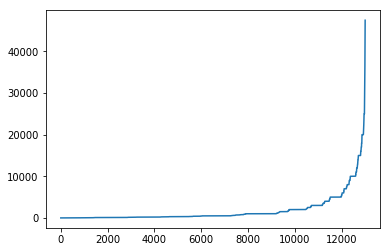

In [127]:
pd.Series(sorted(y_train)).plot()

Видно, что есть выбросы и, возможно, они мешают алгоритму уловить настоящую закономерность, поэтому можно ему помочь, удалив выбросы. 

Делать это можно несколькими способами, но возьмем самый простой, просто выкинем все значения которые больше 95 перцентиля. Кстати, это значение тоже можно подбирать как гиперпараметр.

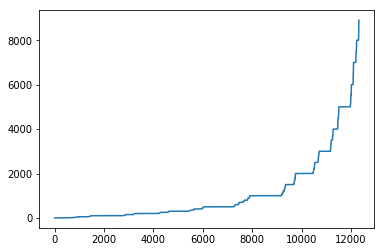

In [128]:
pd.Series(sorted([x for x in y_train if x < np.quantile(y_train, 0.95)])).plot()

Выглядит уже лучше, ставки на 10000 - 40000 уже не участвуют в обучении.

In [129]:
# Формирование новой выборки без выбросов
x_train = np.array(df_x)
y_train = np.array(y)

x_train = x_train[[True if x < np.quantile(y_train, 0.95) else False for x in y_train]]
y_train = [x for x in y_train if x < np.quantile(y_train, 0.95)]


По аналогии с тем как делали выше, посмотрим качество моделей

In [130]:
# Наивная модель где предсказанием является среднее значение полученное на обучающей выборке
regr = DummyRegressor(strategy='mean')
regr_score(x_train, y_train, regr, rmsle)
print()

# Наивная модель где предсказанием является медиана полученная на обучающей выборке
# Эта статистика менее подвержена выбросам, поэтому возможно даст лучшее качество
regr = DummyRegressor(strategy='median')
regr_score(x_train, y_train, regr, rmsle)
print()

# Градиентный бустинг от Микрософта
regr = lgb.LGBMRegressor()
regr_score(x_train, y_train, regr, rmsle)
print()

# К средних соседей
regr = KNeighborsRegressor()
regr_score(x_train, y_train, regr, rmsle)


[2.71190343 2.31330984 1.60983129 1.75684083 1.77779191]
mean score -- 2.033935461952158

[1.98036921 1.62175819 1.47492428 1.8099698  2.18064734]
mean score -- 1.8135337643858425

[1.51084194 1.40883955 1.44891176 1.66332082 1.75189662]
mean score -- 1.556762137280378

[1.31851903 1.4221127  1.60173555 1.82461886 1.85278949]
mean score -- 1.6039551248369093


In [131]:
regr = lgb.LGBMRegressor(n_estimators=66, num_leaves=38)
regr_score(x_train, y_train, regr, rmsle)
print()

regr = KNeighborsRegressor(n_neighbors=4, weights='distance',  p=1)
regr_score(x_train, y_train, regr, rmsle)


[1.36644881 1.35516504 1.45225504 1.66791594 1.75058233]
mean score -- 1.5184734312340538

[1.33479472 1.46249063 1.58680068 1.80824223 1.82684265]
mean score -- 1.603834180756659


Получилось интересно, на очищенных данных бустинг качество лучше чем к средних.

### One Hot Encoding

Можно попробовать за энкодить все признаки, так как они являются по сути категориальными. 

In [132]:
x_train = np.array(df_x)
y_train = np.array(y)

print(x_train.shape)

enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(x_train)
x_train = enc.transform(x_train).toarray()

print(x_train.shape)

(13000, 11)
(13000, 14696)


In [133]:
regr = lgb.LGBMRegressor()
regr_score(x_train, y_train, regr, rmsle)

[2.7389131  2.17752666 1.93327413 1.97231354 2.29513576]
mean score -- 2.223432639012046


ёКачество просело, но это и не удивительно, потому что признаков стало даже больше, чем наблюдений. Но идею преобразования категориальных переменных откидывать не надо, просто нужно сделать это как-нибудь менее топорно.

### merge

Пришло время добавить дополнительные данные

In [134]:
x_train = np.array(df_x)
y_train = np.array(y)

# тут происходит мерж исходных данных и дополнительных, которые мы считали в словарь dfs

df_tmp = pd.merge(df_x, dfs['activity_author'].groupby('activity_id').count().reset_index(),  
                  how='left', 
                  left_on='activity_id', right_on='activity_id', 
                  suffixes=('_x', 'activity_author'))

df_tmp = pd.merge(df_tmp, dfs['event'].groupby('run_id').count().reset_index(),  
                  how='left', 
                  left_on='run_id', right_on='run_id', 
                  suffixes=('_x', '_event'))

df_tmp = pd.merge(df_tmp, dfs['user_role'].drop_duplicates('user_id'),
                  how='left', 
                  left_on='user_id', right_on='user_id', 
                  suffixes=('_x', '_event'))



In [135]:
regr = lgb.LGBMRegressor()
regr_score(df_tmp, y_train, regr, rmsle)
print()


regr = KNeighborsRegressor(n_neighbors=4, weights='distance',  p=1)
regr_score(x_train, y_train, regr, rmsle)



[1.63359241 1.86787261 1.53655134 2.04989471 1.8232366 ]
mean score -- 1.78222953355823

[1.34620249 1.6663659  1.57248305 1.8823089  1.86615139]
mean score -- 1.6667023453319534


In [136]:
df_tmp = df_tmp.join(y)
def prev_sum(row, col1, col2):
    return df_tmp[(df_tmp['user_id'] == row[col1]) & (df_tmp['id_bet'] < row[col2])].label.mean()

df_tmp['prev_sum'] = df_tmp.apply(prev_sum, 
                                  col1 = 'user_id', col2 = 'id_bet', 
                                  axis = 1)
#df_tmp[['user_id', 'label', 'prev_sum']].head()

In [137]:
df_tmp[df_tmp['user_id'] == 898 ][['run_id','user_id', 'label', 'prev_sum']].head()

,run_id,user_id,label,prev_sum
1,135,898,300,NaN
4,951,898,300,300.0
17,114,898,300,300.0
23,225,898,200,300.0
29,235,898,200,275.0


In [138]:
df_tmp = df_tmp.drop('label', axis = 1)
regr = lgb.LGBMRegressor()
regr_score(df_tmp, y_train, regr, rmsle)
print()


regr = KNeighborsRegressor(n_neighbors=4, weights='distance',  p=1)
regr_score(x_train, y_train, regr, rmsle)

[1.64560107 1.71694477 1.53132859 1.97422875 1.84297859]
mean score -- 1.7422163568386462

[1.34620249 1.6663659  1.57248305 1.8823089  1.86615139]
mean score -- 1.6667023453319534


In [139]:
print(df_tmp.shape)
print(len(y))

df_tmp = df_tmp.fillna(-1)
x_train = np.array(df_tmp)
y_train = np.array(y)

x_train = x_train[[True if x < np.quantile(y_train, 0.95) else False for x in y_train]]
y_train = [x for x in y_train if x < np.quantile(y_train, 0.95)]

print(x_train.shape)
print(len(y_train))

(13000, 17)
13000
(12320, 17)
12320


In [140]:
regr = lgb.LGBMRegressor(n_estimators=60, num_leaves=39)
regr_score(x_train, y_train, regr, rmsle)
print()


regr = KNeighborsRegressor(n_neighbors=4, weights='distance',  p=1)
regr_score(x_train, y_train, regr, rmsle)

[1.37717914 1.33130045 1.38169824 1.62049575 1.71651652]
mean score -- 1.4854380204994595

[1.30216881 1.42243852 1.52152323 1.76390779 1.81285067]
mean score -- 1.5645778018080434


In [141]:
regr = lgb.LGBMRegressor(n_estimators=60, num_leaves=39)
regr_score(x_train, y_train, regr, rmsle)
print()


regr = KNeighborsRegressor(n_neighbors=4, weights='distance',  p=1)
regr_score(x_train, y_train, regr, rmsle)



[1.37717914 1.33130045 1.38169824 1.62049575 1.71651652]
mean score -- 1.4854380204994595

[1.30216881 1.42243852 1.52152323 1.76390779 1.81285067]
mean score -- 1.5645778018080434


Качество не улучшилось, но это значит нужно чуть глубже капнуть в дополнительные признаки. 

Можно посмотреть что важно в данных по мнению бустинга

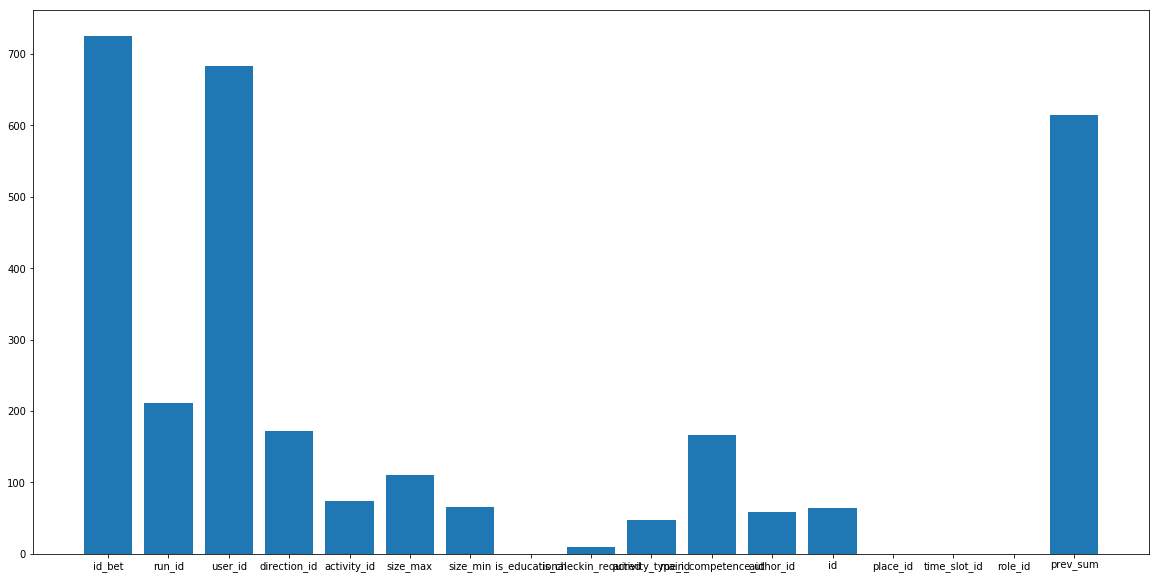

In [142]:
regr = lgb.LGBMRegressor()
regr.fit(x_train, y_train)
pyplot.figure(figsize=(20,10))
pyplot.bar(df_tmp.columns, regr.feature_importances_)
pyplot.show()

Самыми важными признакми являются user_id и id_bet

Можно попробовать посмотреть то же самое, заэнкодив признаки

In [143]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(x_train)
x_train = enc.transform(x_train).toarray()

In [144]:
x_train.shape

(12320, 19836)

In [145]:
regr = lgb.LGBMRegressor()
regr_score(x_train, y_train, regr, rmsle)


[2.40813447 2.01455183 1.57202089 1.78088283 1.9009936 ]
mean score -- 1.9353167250381536


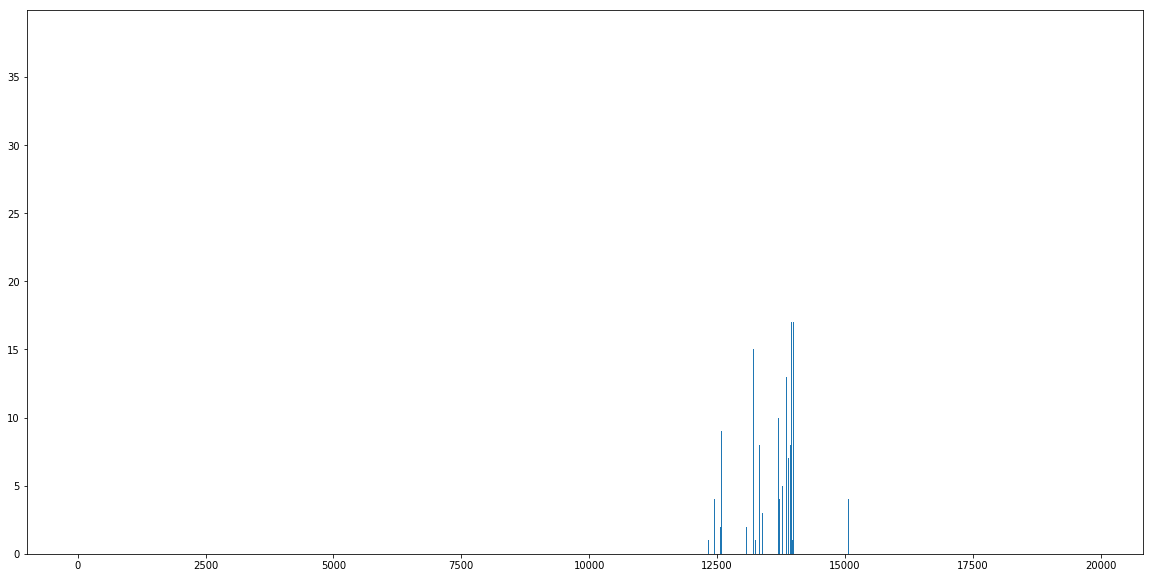

In [146]:
regr = lgb.LGBMRegressor()
regr.fit(x_train, y_train)
pyplot.figure(figsize=(20,10))
pyplot.bar(range(len(regr.feature_importances_)), regr.feature_importances_)
pyplot.show()

### Predict

Сделаем сабмит

In [147]:
df_tmp = pd.merge(df_x, dfs['activity_author'].groupby('activity_id').count().reset_index(),  
                  how='left', 
                  left_on='activity_id', right_on='activity_id', 
                  suffixes=('_x', 'activity_author'))

df_tmp = pd.merge(df_tmp, dfs['event'].groupby('run_id').count().reset_index(),  
                  how='left', 
                  left_on='run_id', right_on='run_id', 
                  suffixes=('_x', '_event'))

df_tmp = pd.merge(df_tmp, dfs['user_role'].drop_duplicates('user_id'),
                  how='left', 
                  left_on='user_id', right_on='user_id', 
                  suffixes=('_x', '_event'))

In [148]:
df_x_test = pd.read_csv(f'{data_dir}/test.csv')
df_x_test = df_x_test.fillna(-1)
df_x_test = df_x_test.drop(['short', 'activity_title', 'title_activity_type',
            'activity_description', 'title_direction', 'comment_direction'], axis=1)


In [149]:
df_test = pd.merge(df_x_test, dfs['activity_author'].groupby('activity_id').count().reset_index(),  
                  how='left', 
                  left_on='activity_id', right_on='activity_id', 
                  suffixes=('_x', 'activity_author'))

df_test = pd.merge(df_test, dfs['event'].groupby('run_id').count().reset_index(),  
                  how='left', 
                  left_on='run_id', right_on='run_id', 
                  suffixes=('_x', '_event'))

df_test = pd.merge(df_test, dfs['user_role'].drop_duplicates('user_id'),
                  how='left', 
                  left_on='user_id', right_on='user_id', 
                  suffixes=('_x', '_event'))

print(df_tmp.columns.values)
print(df_test.columns.values)


['id_bet' 'run_id' 'user_id' 'direction_id' 'activity_id' 'size_max'
 'size_min' 'is_educational' 'is_checkin_required' 'activity_type_id'
 'main_competence_id' 'author_id' 'id' 'place_id' 'time_slot_id' 'role_id']
['id_bet' 'run_id' 'user_id' 'direction_id' 'activity_id' 'size_max'
 'size_min' 'is_educational' 'is_checkin_required' 'activity_type_id'
 'main_competence_id' 'author_id' 'id' 'place_id' 'time_slot_id' 'role_id']


In [150]:
df_tmp = df_tmp.join(y)
def prev_sum(row, col1, col2):
    return df_tmp[(df_tmp['user_id'] == row[col1]) & (df_tmp['id_bet'] < row[col2])].label.mean()

df_test['prev_sum'] = df_test.apply(prev_sum, 
                                  col1 = 'user_id', col2 = 'id_bet', 
                                  axis = 1)

In [161]:
#df_tmp = df_tmp.join(y)
df_tmp['prev_sum'] = df_tmp.apply(prev_sum, 
                                  col1 = 'user_id', col2 = 'id_bet', 
                                  axis = 1)

In [162]:
df_tmp = df_tmp.drop('label', axis = 1)
df_test[['user_id', 'prev_sum']].head()

,user_id,prev_sum
0,602,380.208333
1,509,3708.000000
2,409,1975.000000
3,733,748.571429
4,689,1842.857143


In [159]:
df_test.columns

Index(['id_bet', 'run_id', 'user_id', 'direction_id', 'activity_id',
       'size_max', 'size_min', 'is_educational', 'is_checkin_required',
       'activity_type_id', 'main_competence_id', 'author_id', 'id', 'place_id',
       'time_slot_id', 'role_id', 'prev_sum'],
      dtype='object')

In [160]:
df_tmp.columns

Index(['id_bet', 'run_id', 'user_id', 'direction_id', 'activity_id',
       'size_max', 'size_min', 'is_educational', 'is_checkin_required',
       'activity_type_id', 'main_competence_id', 'author_id', 'id', 'place_id',
       'time_slot_id', 'role_id'],
      dtype='object')

In [153]:
df_tmp = df_tmp.fillna(-1)
df_test = df_test.fillna(-1)


x_train = np.array(df_tmp)
x_test = np.array(df_test)
y_train = np.array(y)


In [163]:
df_tmp = df_tmp.fillna(-1)
x_train = np.array(df_tmp)

y_train = np.array(y)

x_train = x_train[[True if x < np.quantile(y_train, 0.95) else False for x in y_train]]
y_train = [x for x in y_train if x < np.quantile(y_train, 0.95)]

df_test = df_test.fillna(-1)
x_test = np.array(df_test)


In [169]:
regr = lgb.LGBMRegressor(n_estimators=88)
regr.fit(x_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=88, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [170]:
%%time
test_pred = regr.predict(x_test)

CPU times: user 32 ms, sys: 4 ms, total: 36 ms
Wall time: 11.1 ms


In [171]:
submit = pd.concat([df_test['id_bet'], pd.Series(test_pred)], axis=1)
submit.columns=['id_bet', 'label']
submit.to_csv('submit_baseline.csv', index=False)

In [172]:
from IPython.display import HTML
import pandas as pd
import numpy as np
import base64

# function that takes in a dataframe and creates a text link to  
# download it (will only work for files < 2MB or so)
def create_download_link(df, title = "Download CSV file", filename = "data.csv"):  
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)



In [173]:

# create a link to download the dataframe
create_download_link(submit)